In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from pprint import pprint

#BITCOIN API: url setup
url = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
default = 'start=2020-01-01&end=2020-12-31'

# set start and end date variables
# NOTE: must stay within 2020 range, csv files (dow & gold) are limited to this range
start_date = '2020-01-01'
end_date = '2020-12-31'

# DOW: file to Load, read csv, dataframe
file_to_load = "data/dow.csv"
dow_data = pd.read_csv(file_to_load)
dow_data_df = pd.DataFrame(dow_data)

# GOLD: file to load, read csv, dataframe
file_to_load = "data/gold.csv"
gold_data = pd.read_csv(file_to_load)
gold_data_df = pd.DataFrame(gold_data)
gold_data_df.columns = gold_data_df.columns.tolist()[:1] + ['Close'] + gold_data_df.columns.tolist()[2:]

In [19]:
# BITCOIN: create query url for start and end date, request json
query_url = f'{url}start={start_date}&end={end_date}'
pprint(requests.get(query_url).json())

{'bpi': {'2020-01-01': 7188.4633,
         '2020-01-02': 6961.5683,
         '2020-01-03': 7346.58,
         '2020-01-04': 7355.855,
         '2020-01-05': 7356.3117,
         '2020-01-06': 7761.825,
         '2020-01-07': 8157.7617,
         '2020-01-08': 8042.8733,
         '2020-01-09': 7816.9233,
         '2020-01-10': 8189.265,
         '2020-01-11': 8016.4267,
         '2020-01-12': 8178.8833,
         '2020-01-13': 8105.4783,
         '2020-01-14': 8807.4267,
         '2020-01-15': 8808.4867,
         '2020-01-16': 8716.9133,
         '2020-01-17': 8890.25,
         '2020-01-18': 8901.17,
         '2020-01-19': 8698.5717,
         '2020-01-20': 8631.2883,
         '2020-01-21': 8727.6033,
         '2020-01-22': 8661.01,
         '2020-01-23': 8392.145,
         '2020-01-24': 8436.49,
         '2020-01-25': 8337.1017,
         '2020-01-26': 8602.7417,
         '2020-01-27': 8901.5067,
         '2020-01-28': 9393.2733,
         '2020-01-29': 9290.46,
         '2020-01-30': 9508.72

In [20]:
# BITCOIN: create response, create dataframe of date range results from API
response = requests.get(query_url).json()
my_dict = response['bpi']
test_df = pd.DataFrame(list(my_dict.items()),columns = ['close date','close price']) 

# test_df

In [27]:
# DOW: clean data (take out out-of-range data based on start_/end_date variables above)
# return only date and close price columns
dow_cleaned = dow_data_df.loc[(dow_data_df['Date'] >= start_date) & (dow_data_df['Date'] <= end_date)]
dow_cleaned = dow_cleaned[['Date','Close']]

# rename date column to prep for merge
dow_df = dow_cleaned.rename(columns={'Date':'close date'})

dow_cleaned

,Date,Close
1,2020-01-02,28868.800781
2,2020-01-03,28634.880859
3,2020-01-06,28703.380859
4,2020-01-07,28583.679688
5,2020-01-08,28745.089844
...,...,...
249,2020-12-24,30199.869141
250,2020-12-28,30403.970703
251,2020-12-29,30335.669922
252,2020-12-30,30409.560547


In [28]:
# GOLD: clean data - convert to_datetime
gold_data_df['Date'] = pd.to_datetime(gold_data_df['Date'])

# clean data - take out out-of-range data based on start_/end_date variables above
# return only date and close price columns
gold_cleaned = gold_data_df.loc[(gold_data_df['Date'] >= start_date) & (gold_data_df['Date'] <= end_date)]
gold_cleaned = gold_cleaned.sort_values(by=['Date']).reset_index(drop=True)
gold_cleaned = gold_cleaned.iloc[:,0:2]

# rename date column to prep for merge
gold_df = gold_cleaned.rename(columns={'Date':'close date'})

gold_df

,close date,Close
0,2020-01-02,1528.1
1,2020-01-03,1549.2
2,2020-01-06,1568.8
3,2020-01-07,1574.3
4,2020-01-08,1560.2
...,...,...
248,2020-12-24,1883.2
249,2020-12-28,1880.4
250,2020-12-29,1882.9
251,2020-12-30,1893.4


In [29]:
# BITCOIN & 
merged = pd.merge(test_df, dow_df, on='close date', how='left')
merged['close date'] = pd.to_datetime(merged['close date'])

merged = pd.merge(merged, gold_df, on='close date', how='left', suffixes=('_dow','_gold'))
merged = merged.rename(columns={'close date':'Date','close price':'Bitcoin', 'Close_dow':'Dow', 'Close_gold':'Gold'})

merged

,Date,Bitcoin,Dow,Gold
0,2020-01-01,7188.4633,NaN,NaN
1,2020-01-02,6961.5683,28868.800781,1528.1
2,2020-01-03,7346.5800,28634.880859,1549.2
3,2020-01-04,7355.8550,NaN,NaN
4,2020-01-05,7356.3117,NaN,NaN
...,...,...,...,...
361,2020-12-27,26248.2767,NaN,NaN
362,2020-12-28,27041.8667,30403.970703,1880.4
363,2020-12-29,27353.9783,30335.669922,1882.9
364,2020-12-30,28886.0400,30409.560547,1893.4


In [50]:
#drop NaN values (aka weekends & holidays)
merged = merged.dropna()
merged


,Date,Bitcoin,Dow,Gold
1,2020-01-02,6961.5683,28868.800781,1528.1
2,2020-01-03,7346.5800,28634.880859,1549.2
5,2020-01-06,7761.8250,28703.380859,1568.8
6,2020-01-07,8157.7617,28583.679688,1574.3
7,2020-01-08,8042.8733,28745.089844,1560.2
...,...,...,...,...
358,2020-12-24,23729.6483,30199.869141,1883.2
362,2020-12-28,27041.8667,30403.970703,1880.4
363,2020-12-29,27353.9783,30335.669922,1882.9
364,2020-12-30,28886.0400,30409.560547,1893.4


In [32]:
# setting axes to variables
bitcoin_x = merged['Bitcoin']
dow_x = merged['Dow']
gold_x = merged['Gold']
all_y = merged['Date']

In [33]:
# set up colors
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

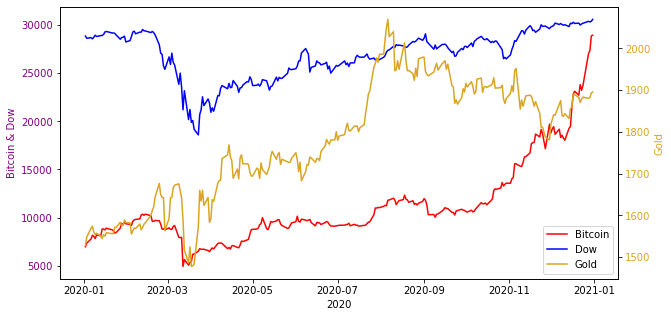

In [34]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()

# here's the link to the info on overlaying two axes: 
# https://matplotlib.org/gallery/api/two_scales.html

# link to combining all plots into one legend:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

# link to changing fig size
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

In [46]:
merged.describe()

,Bitcoin,Dow,Gold
count,253.000000,253.000000,253.000000
mean,11143.665731,26890.673612,1779.100791
std,4298.440906,2521.704585,142.015038
min,4914.085000,18591.929688,1477.900000
25%,8890.250000,25595.800781,1675.700000
50%,9730.365000,27480.029297,1788.100000
75%,11744.012700,28823.769531,1895.500000
max,28956.265000,30606.480469,2069.400000


,close date,close price
0,2020-01-01,7188.4633
1,2020-01-02,6961.5683
2,2020-01-03,7346.5800
3,2020-01-04,7355.8550
4,2020-01-05,7356.3117
...,...,...
361,2020-12-27,26248.2767
362,2020-12-28,27041.8667
363,2020-12-29,27353.9783
364,2020-12-30,28886.0400


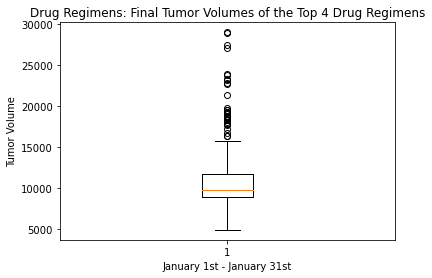

In [49]:
fig1, ax1 = plt.subplots()
ax1.set_title('Drug Regimens: Final Tumor Volumes of the Top 4 Drug Regimens')
ax1.set_ylabel('Tumor Volume')
ax1.boxplot(merged['Bitcoin'])
plt.xlabel('January 1st - January 31st')
plt.show()

#make data folder outside jupyter notebook

## TO DO:
* Meredith: covid border shut down: february 28-march 26, 2020
* Darren: george floyd/social protests: may 25-june 25, 2020
* Ryan: election: nov 2-nov 9
* Emi: move to Maryland (good luck!)
* Chelsea: year data?


In [51]:
#NEW SECTION: Look between dates 01-01-2020 to 01-31-2020
start_date = '11-01-2020'
end_date = '11-14-2020'

new_df = merged.loc[(merged['Date'] >= start_date) & (merged['Date'] <= end_date)]

new_df

,Date,Bitcoin,Dow,Gold
306,2020-11-02,13567.2233,26925.050781,1892.5
307,2020-11-03,14030.7900,27480.029297,1910.4
308,2020-11-04,14158.8100,27847.660156,1896.2
309,2020-11-05,15593.5550,28390.179688,1946.8
310,2020-11-06,15589.0033,28323.400391,1951.7
313,2020-11-09,15334.8700,29157.970703,1854.4
314,2020-11-10,15313.4433,29420.919922,1876.4
315,2020-11-11,15706.5400,29397.630859,1861.6
316,2020-11-12,16301.0267,29080.169922,1873.3
317,2020-11-13,16330.3433,29479.810547,1886.2


In [52]:
# setting axes to variables
bitcoin_x = new_df['Bitcoin']
dow_x = new_df['Dow']
gold_x = new_df['Gold']
all_y = new_df['Date']

In [53]:
# set up colors
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

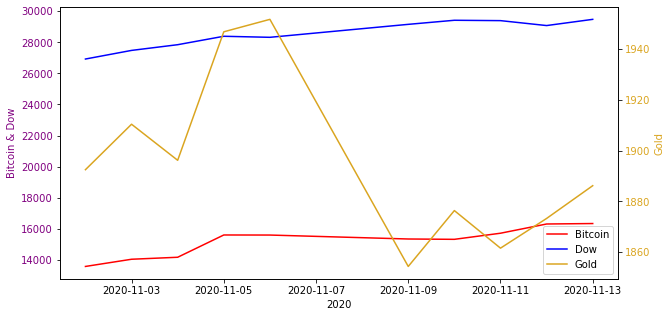

In [54]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()
